In [13]:
from __future__ import print_function
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt
import scipy.ndimage.filters as fi
from PIL import Image
import scipy.stats as st
import numpy as np
import cv2

In [14]:
def gkern(kernlen, nsig): #21,3
    """Returns a 2D Gaussian kernel array."""
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.max()
    return kernel

def blur_edge(img, d=31):
    h, w  = img.shape[:2]
    img_pad = cv2.copyMakeBorder(img, d, d, d, d, cv2.BORDER_WRAP)
    img_blur = cv2.GaussianBlur(img_pad, (2*d+1, 2*d+1), -1)[d:-d,d:-d]
    y, x = np.indices((h, w))
    dist = np.dstack([x, w-x-1, y, h-y-1]).min(-1)
    w = np.minimum(np.float32(dist)/d, 1.0)
    return img*w + img_blur*(1-w)

def motion_kernel(angle, d, sz=65):
    kern = np.ones((1, d), np.float32)
    c, s = np.cos(angle), np.sin(angle)
    A = np.float32([[c, -s, 0], [s, c, 0]])
    sz2 = sz // 2
    A[:,2] = (sz2, sz2) - np.dot(A[:,:2], ((d-1)*0.5, 0))
    kern = cv2.warpAffine(kern, A, (sz, sz), flags=cv2.INTER_CUBIC)
    return kern

def defocus_kernel(d, sz = 65):
    kern = np.zeros((sz, sz), np.uint8)
    cv2.circle(kern, (sz, sz), d, 255, -1, cv2.LINE_AA, shift=1)
    kern = np.float32(kern) / 255.0
    return kern


Blurred Image


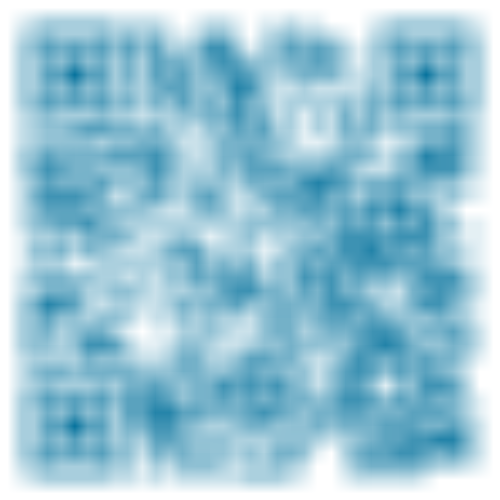

Deblurred_Image


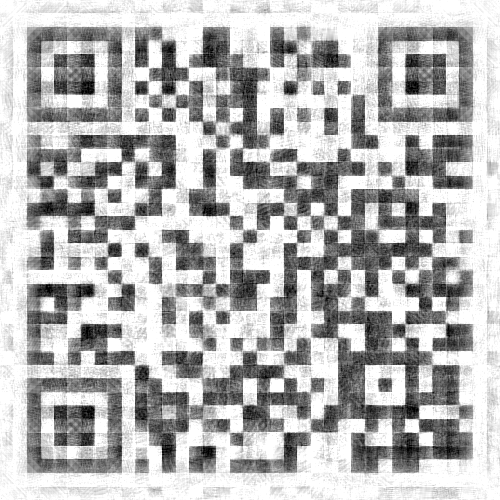

In [15]:
Blurred_Image = "misc/40.png"
Deblurred_Image = "misc/Deblurred.png"
kernel = 40
nsig = 0
noise = 10**(-0.1*50)

img_bw = cv2.imread(Blurred_Image, 0)
img_rgb = cv2.imread(Blurred_Image, 1)

img_r = np.zeros_like(img_bw)
img_g = np.zeros_like(img_bw)
img_b = np.zeros_like(img_bw)

img_r = img_rgb[..., 0]
img_g = img_rgb[..., 1]
img_b = img_rgb[..., 2]

img_rgb = np.float32(img_rgb)/255.0
img_bw = np.float32(img_bw)/255.0
img_r = np.float32(img_r)/255.0
img_g = np.float32(img_g)/255.0
img_b = np.float32(img_b)/255.0

img_r = blur_edge(img_r)
img_g = blur_edge(img_g)
img_b = blur_edge(img_b)

IMG_R = cv2.dft(img_r, flags=cv2.DFT_COMPLEX_OUTPUT)
IMG_G = cv2.dft(img_g, flags=cv2.DFT_COMPLEX_OUTPUT)
IMG_B = cv2.dft(img_b, flags=cv2.DFT_COMPLEX_OUTPUT)

psf = gkern(kernel, nsig)
psf /= psf.sum()
psf_pad = np.zeros_like(img_bw)
kh, kw = psf.shape
psf_pad[:kh, :kw] = psf
PSF = cv2.dft(psf_pad, flags = cv2.DFT_COMPLEX_OUTPUT, nonzeroRows = kh)
PSF2 = (PSF**2).sum(-1)
iPSF = PSF / (PSF2 + noise)[...,np.newaxis]

RES_R = cv2.mulSpectrums(IMG_R, iPSF, 0)
RES_G = cv2.mulSpectrums(IMG_G, iPSF, 0)
RES_B = cv2.mulSpectrums(IMG_B, iPSF, 0)


res_r = cv2.idft(RES_R, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
res_g = cv2.idft(RES_G, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
res_b = cv2.idft(RES_B, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )

res_rgb = np.zeros_like(img_rgb)
res_rgb[..., 0] = res_r
res_rgb[..., 1] = res_g
res_rgb[..., 2] = res_b

res_rgb = np.roll(res_rgb, -kh//2, 0)
res_rgb = np.roll(res_rgb, -kw//2, 1)

#print(res_rgb.shape)

res_rgb = (res_rgb * 255).round()
res_rgb = cv2.cvtColor(res_rgb, cv2.COLOR_BGR2GRAY)
cv2.imwrite(Deblurred_Image, res_rgb)

print("Blurred Image")
display(Image.open(Blurred_Image))

print("Deblurred_Image")
display(Image.open(Deblurred_Image))
